# RDBMS - MySQL 

## 00 - Introduction

Among the Relational DBMSs, the most widely known are Oracle, SQLite, Postgress, MariaDB, MySQL.

Each one of them is characterized by a different set of "variations" on top of the base SQL language, although usually minor.

We will use **MySQL** to run exercises about Relational DB transactions using the SQL language, as it is *today* at the top of the list of most widely used RDBs. 

https://db-engines.com/en/ranking_trend/relational+dbms

https://www.statista.com/statistics/809750/worldwide-popularity-ranking-database-management-systems/

https://insights.stackoverflow.com/survey/2021#most-popular-technologies-database

MySQL programming interfaces exist for many languages, including C, C++, Go, Java, Perl, PHP, Python, etc...

Even simply referring to Python, we can count on several options to connect and interact with the DBs. 

Let's explore a couple of them...

## 01 - Create a connection to MySQL 

A MySQL server is in execution on one of your Docker containers.

We can access it via the MySQL server credential we have defined in the docker-compose yml.

A `root` user is created by default with:
- user: `root`
- password: `root_pwd`

A non-`root` user is also created by default with:
- user: `my_user`
- password: `my_pwd`

#### Interactive 

We can interact with the MySQL server by logging in interactively to its docker container.

Check the `CONTAINER ID` of the container named `mysql_db` via:
    
```bash 
$ docker ps 
```

And run `bash` (or `/bin/bash`) in interactive mode attaching it to the terminal (`-it`) on the container:

```bash
$ docker exec -it <YOUR CONTAINER ID> bash
```

From inside the container we can use the RDBMS interface as if we were logged into a remote MySQL server hosting our DBs

```bash
$ mysql -u <EITHER ROOT OR USER> -p
``` 

We can then inspect the MySQL server to show us all DBs:
    
```mysql
SHOW DATABASES;
```

_NB_: remember to end a SQL command with a semicolon `;`

#### mysql.connector

A more pythonic way of communicating with a MySQL server is by using a dedicated driver.

We will use `mysql.connector`, which has already been installed in the Jupyter-notebook container for you.

The connector offers an interface to declare a connection object to the server, and provides a series of functionalities to issue transactions and fetch records from DBs.

We start by declaring a connection to our MySQL server.

_NB_: the server is hosted in a different container from the notebook... we are simulating a connection between two differen machines, a client and a server.

In [337]:
# import the connector
import mysql.connector

# declare a connection to the MySQL server 
# the hostname (or IP) of the server machine should be passed
db = mysql.connector.connect(
  user="root",
  password="root_pwd",
  host="db", # in this case 'db' is the equivalent of the IP address of the server 
             # or 'localhost' if running mysql locally
)

print(db)

At this point a DB connection is enstablished

To interact with the DB via python and mysql.connector we need a "handle", known as a cursor, which has to be instantiated.

Using this connector to interact with the DB, all SQL statements are executed using the cursor.

In [338]:
# create our db cursor object
dbc = db.cursor()

The cursor allows to execute all SQL transactions on the DB as if we were logged into the server.

If a transaction will fetch a result from the DB (a set of records are returned), the connector object will retain the results.

This might come in handy for us to use it in a more "pythonic" way later on, interfacing our DB query with other Python statements.

The syntax for issuing a generic SQL statement is the following:

```python
connector_object.execute(my_sql_query)
```

For instance, let's try to execute the same check as before, by asking MySQL to show us all available DBs...

In [339]:
# show all available databases
dbc.execute(
"SHOW DATABASES"
)

No output is printed as the result of this SQL transaction is in fact "collected" into the cursor as a list of records (tuples).

We can simply loop over them to return the results.

In [340]:
# loop over the container to fetch the results
for _ in dbc:
    print(_)

('IMDb_pruned',)
('information_schema',)
('my_db',)
('mysql',)
('performance_schema',)
('sys',)
('world',)


If we are `root` users in this example, we are able to see inner structure of the mysql server, which already contains a few dbs by default. 

Once fetched the output of the transaction, the cursor reaches "the end" of the records, and is available to perform a new transaction

In [341]:
# use fetch to retrieve one, many, or all entries in the cursor
dbc.fetchone()

# dbc.fetchmany(2)

# dbc.fetchall()

In the case one wants to perform a new transaction without collecting the output of the previos one from the cursor, a reset have to be issued first:

```python 
connector_object.reset()
```


In the case a generic user is instead logged into the db (i.e. non the `root` user), it will not have access to a set of functionalities, and will not be able to see the previous list of all databases.

Some of those are in fact protected and used to store additional information on the state of the MySQL server, the users connected, ...

In [342]:
udb = mysql.connector.connect(
  user="new_user",
  password="YES",
  host="db",
)

udbc = udb.cursor()

udbc.execute(
"SHOW DATABASES"
)

udbc.fetchall()

ProgrammingError: 1045 (28000): Access denied for user 'new_user'@'172.18.0.3' (using password: YES)

#### iPython magic

An alternative way to perform queries from Python over a Jupyter-notebook is by using some notebook "magic", based on iPython and SQLAlchemy.

This is a similar thing to what is usually done to load inline a figure from matplotlib (the `%matplotlib inline` thingy).

To instruct iPython to interpret SQL commands, and to connect to the proper DB we have to: 
1. load the extension for SQL language
2. set the environment variable to point to the connection to the DB

In [ ]:
%load_ext sql

%env DATABASE_URL=mysql+mysqlconnector://root:root_pwd@db

Now, the notebooks cells can perform SQL transactions directly in plain SQL, by starting the cell with `%%sql`.

By default, the result is also printed with the `pretty` pandas-like format.

In [ ]:
%%sql

SHOW DATABASES;

An additional benefit is that a single `%slq` (not a double `%%sql`) can be used to join a SQL query with any Python command

In [343]:
my_python_var = %sql SHOW DATABASES

print(my_python_var)

 * mysql+mysqlconnector://root:***@db
7 rows affected.
+--------------------+
|      Database      |
+--------------------+
|    IMDb_pruned     |
| information_schema |
|       my_db        |
|       mysql        |
| performance_schema |
|        sys         |
|       world        |
+--------------------+


The combination of either of the two pythonic methods can be used to easily redirect the output of DB transactions to exploit all other well-known python modules, e.g. plotting with matplotlib

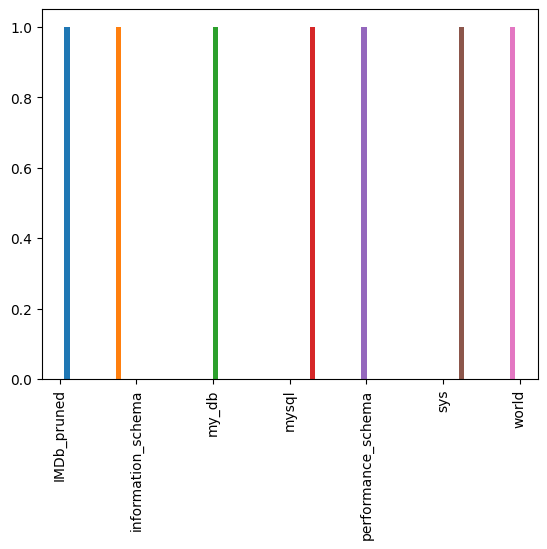

In [344]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(my_python_var);
plt.xticks(rotation='vertical');

## 02 Database and Table creation

We have already seen how we inspect the server to see which DBs are present via the command:

```mysql
SHOW DATABASES;
```

We can start interacting with a specific DB by selecting which one to use via 

```mysql
USE <DB_NAME>;
```

If instead we want to create a new DB to work with, we can use the command

```mysql
CREATE DATABASE <DB_NAME>;
```

A more complex sintax can be used to create a new DB if and only if no other DB with the same name already exists.

```mysql
CREATE DATABASE IF NOT EXISTS <DB_NAME>;
```

If the user has been granted the right to access this DB, it's possible to start investigating the content of the DB in use.

Check if a DB named `my_db` exist, and if not, create one. 
Then, switch to the new DB to start using it.

In [345]:
%%sql

CREATE DATABASE IF NOT EXISTS my_db;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [346]:
%%sql

SHOW DATABASES;

 * mysql+mysqlconnector://root:***@db
7 rows affected.


Database
IMDb_pruned
information_schema
my_db
mysql
performance_schema
sys
world


In [347]:
%%sql

USE my_db;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

All tables contained in the DB are shown in a similar way to what used to show all DBs on the server:

```mysql
SHOW TABLES;
```

_NB_: we are inspecting the content of a specific DB (the one selected with `USE <DB_NAME>`)

In [348]:
%%sql 

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Tables_in_my_db
products
supplier_to_product
suppliers


The analogous pythonic way to execute the same list of commands (using the mysql.connector driver) is the following.

_NB_: This time, as we are not retrieving results from the server but we are instead creating a DB, we have to specify that we want to _commit_ a change to the server; 

In [349]:
# defining the sql command line
sql_ = "CREATE DATABASE IF NOT EXISTS my_db;"

# instructing the cursor to execute it
dbc.execute(sql_)

# in this case the result of the sql transaction is not to return a list of items 
# it is instead a change in the DB structure
# therefore, for the change to have effect, a the change is to be committed to the DB
db.commit() 

All other commands, `USE` and `SHOW`, do not require any change to be committed, therefore we can simply issue them via the cursor.

In [350]:
dbc.execute("USE my_db")

dbc.execute("SHOW TABLES")
dbc.fetchall()

('products',)
('supplier_to_product',)
('suppliers',)


So far the DB is empty, so let's use the same lines presented in the slides to create a dummy `Users` table.

Any table can then be inspected to check its schema by listing all attributes.

1. Create the `Users` table declaring the schema by defining each attributes
2. Check if the table has been created on the DB via a `SHOW` command
3. Check the Table schema by issuing `DESCRIBE <TABLE_NAME>`

In [351]:
%%sql

CREATE TABLE Users (
    UserID varchar(30),
    BadgeNum int(16),
    FirstName varchar(255),
    LastName varchar(255),
    Age int,
    OtherAttr float
);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [352]:
%%sql 

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Tables_in_my_db
Users
products
supplier_to_product
suppliers


In [353]:
%%sql

DESCRIBE Users;

 * mysql+mysqlconnector://root:***@db
6 rows affected.


Field,Type,Null,Key,Default,Extra
UserID,varchar(30),YES,,None,
BadgeNum,int,YES,,None,
FirstName,varchar(255),YES,,None,
LastName,varchar(255),YES,,None,
Age,int,YES,,None,
OtherAttr,float,YES,,None,


Following on the lines of the previous examples, perform the same transactions with the `mysql.connector` driver.

This time, as the `Users` table already exists, we can create a `Users_py` table.

Remember:
- Use the DB Cursor to execute the transactions
- Transaction that change the content of the DB have to be _committed_ to the DB
- Transactions returing the content of the DB host their results _in the cursor_

In [354]:
dbc.reset()

In [355]:
dbc.execute("DESCRIBE Users_py")

ProgrammingError: 1146 (42S02): Table 'my_db.Users_py' doesn't exist

In [356]:
# create table
sql_ = "CREATE TABLE Users_py (\
    UserID varchar(30),\
    BadgeNum int(16),\
    FirstName varchar(255),\
    LastName varchar(255),\
    Age int,\
    OtherAttr float\
);"

dbc.execute(sql_)

db.commit()

In [357]:
dbc.execute("SHOW TABLES")

In [358]:
dbc.fetchall()

('Users',)
('Users_py',)
('products',)
('supplier_to_product',)
('suppliers',)


In [359]:
# describe table
dbc.execute("DESCRIBE Users_py")

In [360]:
dbc.fetchall()

('UserID', 'varchar(30)', 'YES', '', None, '')
('BadgeNum', 'int', 'YES', '', None, '')
('FirstName', 'varchar(255)', 'YES', '', None, '')
('LastName', 'varchar(255)', 'YES', '', None, '')
('Age', 'int', 'YES', '', None, '')
('OtherAttr', 'float', 'YES', '', None, '')


## 03 Declaring contstraints and altering tables

Let's clean up all existing tables in our database.

To remove an existing table from a DB we can issue the instruction:
    
```mysql
DROP TABLE IF EXISTS <NAME OF YOUR TABLE>;
```

Be ***extremely careful*** when doing this... Dropping a Table means losing all records from that table, and severing all connections with other tables based on foreign keys. The entire DB might become unusable!


In [361]:
%%sql 

DROP TABLE IF EXISTS Users;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

Let's also drop the `Users_py` table using the Python connetor

In [362]:
dbc.execute("DROP TABLE IF EXISTS Users_py")
db.commit()

Create a new `products` table with the following schema:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |

`productID` will also be our `PRIMARY KEY`

This can be declared either inline or at the end of the table definition:

```mysql
productID INT NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY
```

or 

```mysql
productID INT NOT NULL UNIQUE AUTO_INCREMENT
...
PRIMARY KEY (productID)
```

In [363]:
%%sql

CREATE TABLE IF NOT EXISTS products (
         productID    INT          NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY,
         productName  VARCHAR(30)  DEFAULT "" ,
         unitPrice    FLOAT        NOT NULL DEFAULT 99999.99,
         unitsInStock INT UNSIGNED NOT NULL DEFAULT 0
);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [364]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,int,NO,PRI,None,auto_increment
productName,varchar(30),NO,,,
unitPrice,float,NO,,100000,
unitsInStock,int unsigned,NO,,0,
isDiscontinued,tinyint(1),NO,,0,


The table does not contain any constraint, default values, or keys.

A table can be altered by adding/removing Attributes, as well as by adding constraints.

Let's first add a new attribute to the table:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |
| **isDiscontinued**  | **Bool** | | NOT NULL |

To alter a table and create a new column we can act on it with:

```mysql
ALTER TABLE <THE TABLE>
ADD COLUMN <NEW COL> <THE NEW ATTRIBUTE DECLARATION>;
```


Alter the `products` table and add the `isDiscontinued` attribute

In [365]:
%%sql

ALTER TABLE products
ADD COLUMN isDiscontinued BOOL NOT NULL;

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1060 (42S21): Duplicate column name 'isDiscontinued'
[SQL: ALTER TABLE products
ADD COLUMN isDiscontinued BOOL NOT NULL;]
(Background on this error at: https://sqlalche.me/e/14/f405)


In [366]:
%%sql 

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,int,NO,PRI,None,auto_increment
productName,varchar(30),NO,,,
unitPrice,float,NO,,100000,
unitsInStock,int unsigned,NO,,0,
isDiscontinued,tinyint(1),NO,,0,


`isDiscontinued` does however not contain any meaningful constraint or default value.
Let's consider `0` as a good default value:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |
| isDiscontinued  | Bool | | NOT NULL **DEFAULT 0** |


We can use the same `ALTER TABLE` instruction to do this:
    
```mysql
ALTER TABLE <THE TABLE>
ALTER <ATTRIBUTE> SET DEFAULT <NEW DEFAULT>;
```

In [367]:
%%sql

ALTER TABLE products
ALTER isDiscontinued SET DEFAULT 0;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [368]:
%%sql 

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,int,NO,PRI,None,auto_increment
productName,varchar(30),NO,,,
unitPrice,float,NO,,100000,
unitsInStock,int unsigned,NO,,0,
isDiscontinued,tinyint(1),NO,,0,


We can also impose `productName` to be not-null altering the table one final time.

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | **NOT NULL** DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |
| isDiscontinued  | Bool | | NOT NULL DEFAULT 0 |


In MySQL, this implies to modify the entire attribute, thus the Type will have to be re-stated:
    
```mysql
ALTER TABLE <THE TABLE>
MODIFY <ATTRIBUTE> <ATTRIBUTE TYPE> <CONSTRAINT>;
```

In [369]:
%%sql

ALTER TABLE products
MODIFY productName VARCHAR(30) NOT NULL DEFAULT "";

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [370]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,int,NO,PRI,None,auto_increment
productName,varchar(30),NO,,,
unitPrice,float,NO,,100000,
unitsInStock,int unsigned,NO,,0,
isDiscontinued,tinyint(1),NO,,0,


Let's now create a `suppliers` table with the following description:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| supplierID   | Integer | | NOT NULL AUTO_INCREMENT |
| supplierName | String | Max length 30 | NOT NULL DEFAULT "" |
| countryCode   | Char | Length 3 | NOT NULL |
| email   | String | Max length 30  | NOT NULL |

`supplierID` is going to act as the table's primary key in this case.

In [371]:
%%sql

CREATE TABLE suppliers (
    supplierID      INT NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY,
    supplierName    VARCHAR(30) NOT NULL DEFAULT "",
    countryCode     CHAR(3) NOT NULL,
    email           VARCHAR(30) NOT NULL
);


 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1050 (42S01): Table 'suppliers' already exists
[SQL: CREATE TABLE suppliers (
    supplierID      INT NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY,
    supplierName    VARCHAR(30) NOT NULL DEFAULT "",
    countryCode     CHAR(3) NOT NULL,
    email           VARCHAR(30) NOT NULL
);]
(Background on this error at: https://sqlalche.me/e/14/f405)


In [372]:
%%sql

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
supplierID,int,NO,PRI,None,auto_increment
supplierName,varchar(30),NO,,,
countryCode,char(3),NO,,ITA,
email,varchar(30),NO,,None,


Alter the table to include a default "ITA" for `countryCode`

In [373]:
%%sql 

ALTER TABLE suppliers 
ALTER countryCode SET DEFAULT "ITA";

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [374]:
%%sql

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
supplierID,int,NO,PRI,None,auto_increment
supplierName,varchar(30),NO,,,
countryCode,char(3),NO,,ITA,
email,varchar(30),NO,,None,


In [375]:
%%sql

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Tables_in_my_db
products
supplier_to_product
suppliers


To enstablish a relation between the `products` and `suppliers` tables, we have to consider that:
    
- a supplier can supply multiple products
- a product can be supplied by multiple suppliers

This is a many-to-many relationship, which requires a supporting external table.

Create a new `supplier_to_product` table with the following attributes:
    
| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| prodID   | Integer | | NOT NULL |
| supID    | Integer | | NOT NULL |


In [376]:
%%sql 

CREATE TABLE supplier_to_product(
    prodID INT NOT NULL,
    supID  INT NOT NULL
);

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1050 (42S01): Table 'supplier_to_product' already exists
[SQL: CREATE TABLE supplier_to_product(
    prodID INT NOT NULL,
    supID  INT NOT NULL
);]
(Background on this error at: https://sqlalche.me/e/14/f405)


In [377]:
%%sql 

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
prodID,int,NO,PRI,None,
supID,int,NO,PRI,None,


Neither prodID nor supID is a good primary key in this case, as we can have both appearing multiple times in the table.

However, a good primary key for this table is the combination (prodID,supID) which is absolutely unique, and thus, a good key.

We can alter the table to add the primary key statement:
    
```mysql
ALTER TABLE <TABLE>
ADD PRIMARY KEY <ATTRIBUTE COMBINATION>;
```

In [378]:
%%sql

ALTER TABLE supplier_to_product
ADD PRIMARY KEY (prodID,supID);

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1068 (42000): Multiple primary key defined
[SQL: ALTER TABLE supplier_to_product
ADD PRIMARY KEY (prodID,supID);]
(Background on this error at: https://sqlalche.me/e/14/f405)


In [379]:
%%sql

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
prodID,int,NO,PRI,None,
supID,int,NO,PRI,None,


Finally, we can link the 3 tables together by stating which attributes act as the foreign keys in the `supplier_to_product` table, and to which Attributes in the parent tables they refer to.

- `prodID` points to the `productID` attribute of `products` table
- `supID` points to the `supplierID` attribute of `supplier` table

```mysql
ALTER TABLE <TABLE>
ADD FOREIGN KEY (<ATTRIBUTE IN THIS TABLE>) REFERENCES <OTHER TABLE>(<ATTRIBUTE IN OTHER TABLE>);
```

In [380]:
%%sql 

ALTER TABLE supplier_to_product 
ADD CONSTRAINT FK_prod
FOREIGN KEY (prodID) REFERENCES products(productID);

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.DatabaseError) 1826 (HY000): Duplicate foreign key constraint name 'FK_prod'
[SQL: ALTER TABLE supplier_to_product 
ADD CONSTRAINT FK_prod
FOREIGN KEY (prodID) REFERENCES products(productID);]
(Background on this error at: https://sqlalche.me/e/14/4xp6)


In [381]:
%%sql 

ALTER TABLE supplier_to_product 
ADD CONSTRAINT FK_sup
FOREIGN KEY (supID) REFERENCES suppliers(supplierID);

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.DatabaseError) 1826 (HY000): Duplicate foreign key constraint name 'FK_sup'
[SQL: ALTER TABLE supplier_to_product 
ADD CONSTRAINT FK_sup
FOREIGN KEY (supID) REFERENCES suppliers(supplierID);]
(Background on this error at: https://sqlalche.me/e/14/4xp6)


In [382]:
%%sql

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
prodID,int,NO,PRI,None,
supID,int,NO,PRI,None,


## 04 Inserting Updating and Deleting records

The tables are currently empty. 
We can inspect the content of the tables by performing a simple query.

```mysql
SELECT * FROM <TABLE>;
```

To insert a single record into a table we can proceed in either of the two following ways:

1. By explicitly specifying the names of the columns when passing the tuple containing the values
```mysql
INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...)
VALUES (<VALUE1>, <VALUE2>, <VALUE3>, ...);
```
This will work also in the case attributes with a default value will not be explicitely passed


2. By implicitly using all the columns when passing the tuple containing the values
```mysql
INSERT INTO <TABLE> 
VALUES (<VALUE1>, <VALUE2>, ..., <VALUEn>);
```


_NB_: 1. is the usually recommended way to perform a data insertion in SQL.

Using the `mysql.connector` we can formulate the insert in a more pythonic way, e.g. to include this statement programmatically into a loop or a function call:
    
```python
sql_ = "INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...) VALUES (%s, %s, %s, ...)"
val_ = (<VALUE1>, <VALUE2>, <VALUE3>, ...)
db_cursor.execute(sql_, val_)
db.commit()
```

Being an active change to the DB istance (the data contained in the DB itself), remember to commit the insert.

- Verify that the product table is actually empty
- Isert the following list of products in the `products` table
- Check the content of the table after the transaction, to verify that both the AUTO_INCREMENT key and the default values have taken into account


| productName | unitPrice | unitsInStock | isDiscontinued | 
| --- | --- | --- |--- |
| "Founders Porter" | 4.9 | 12 | 0 |


In [383]:
%%sql

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
28 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0
6,Founders Porter,4.9,12,0
7,Punk IPA,5.2,45,0
8,HB Dunkel,4.5,250,0
10,Damm Complot,3.7,120,0
11,Founders Porter,4.9,12,0
12,Punk IPA,5.2,45,0


In [384]:
%%sql

INSERT INTO products (productName, unitPrice, unitsInStock, isDiscontinued)
VALUES ("Founders Porter", 4.9, 12, 0);

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [385]:
%%sql

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
29 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0
6,Founders Porter,4.9,12,0
7,Punk IPA,5.2,45,0
8,HB Dunkel,4.5,250,0
10,Damm Complot,3.7,120,0
11,Founders Porter,4.9,12,0
12,Punk IPA,5.2,45,0


Multi-values insert can be performed in a completely similar way, by separating multiple tuples by a comma:
    
```mysql
INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...)
VALUES 
(<VALUE11>, <VALUE12>, <VALUE13>, ...), 
(<VALUE21>, <VALUE22>, <VALUE23>, ...), 
(<VALUE31>, <VALUE32>, <VALUE33>, ...), 

```

The python-based command is similar to the previous one, but is drop the `execute` in favor of `executemany`, using as value a list of tuples

```python
sql_ = "INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...) VALUES (%s, %s, %s, ...)"
val_ = [
    (<VALUE11>, <VALUE12>, <VALUE13>, ...),
    (<VALUE21>, <VALUE22>, <VALUE23>, ...),
    (<VALUE31>, <VALUE32>, <VALUE33>, ...) ]
db_cursor.executemany(sql_, val_)
db.commit()
```


Add a few more products to the `product` table:
    
| productName | unitPrice | unitsInStock | isDiscontinued | 
| --- | --- | --- |--- |
| "Punk IPA" | 5.2 | 45 |  |
| "HB Dunkel" | 4.5 | 250 |  |
| "Forst Xmas " | 8.0 | 2 |  |
| "Damm Complot " | 3.7 | 120 |  |
     

In [386]:
%%sql

INSERT INTO products (productName, unitPrice, unitsInStock)
VALUES     ('Punk IPA',     5.2,  45),
    ('HB Dunkel',    4.5, 250),
    ('Forst Xmas',   8.0,   2),
    ('Damm Complot', 3.7, 120);


 * mysql+mysqlconnector://root:***@db
4 rows affected.


[]

In [387]:
%%sql 

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
33 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0
6,Founders Porter,4.9,12,0
7,Punk IPA,5.2,45,0
8,HB Dunkel,4.5,250,0
10,Damm Complot,3.7,120,0
11,Founders Porter,4.9,12,0
12,Punk IPA,5.2,45,0


Updating entries is a more delicate issue, as in a DB we can in principle modify all records associated with a number of conditions.
This makes the update operation quite powerful and possibly very error prone if not performed with extreme caution.

```mysql
UPDATE <TABLE>
SET <ATTRIBUTE> = <NEW VALUE>
WHERE <CONDITION>;
```

or

```python
sql_ = "UPDATE <TABLE> SET <ATTRIBUTE> = <NEW VALUE> WHERE <CONDITION>"
db_cursor.execute(sql)
db.commit()

```

Let's update a single record with a "very explicit" condition statement:

- Assign `isDiscontinued` equal to 1 to the "Forst Xmas" product
- Check if the update has taken place

In [388]:
%%sql

UPDATE products
SET isDiscontinued = 1
WHERE (productName = "Forst Xmas");

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [389]:
%%sql

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
33 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0
6,Founders Porter,4.9,12,0
7,Punk IPA,5.2,45,0
8,HB Dunkel,4.5,250,0
10,Damm Complot,3.7,120,0
11,Founders Porter,4.9,12,0
12,Punk IPA,5.2,45,0


Similarly, deleting entries is quite a risky task if not done with plenty of caution, as a wrong `WHERE` condition might inadvertly lead to the deletion of a large part of your DB records. 

Remember, with `DELETE` we do remove entire records (i.e. tuples) from the DB, not just the content of the `WHERE` conditional statement. 

```mysql
DELETE FROM <TABLE>
WHERE <CONDITION>;
```

or

```python
sql_ = "DELETE FROM <TABLE> WHERE <CONDITION>"
db_cursor.execute(sql)
db.commit()

```

- Delete all products whose name begins with 'F' and ends with 's'
- Check if the update has taken place

In [390]:
%%sql

DELETE FROM products
WHERE (productName LIKE 'F%s');

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [391]:
%%sql

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
32 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0
6,Founders Porter,4.9,12,0
7,Punk IPA,5.2,45,0
8,HB Dunkel,4.5,250,0
10,Damm Complot,3.7,120,0
11,Founders Porter,4.9,12,0
12,Punk IPA,5.2,45,0


- Populate the `suppliers` table according to the following list


| supplierName | countryCode | email|
| --- | --- | ---|
| "A hop in the park" | "USA" | "contactme@ahop.com" |
| "Allez Hops! Cave à bièr" | "FRA" | "itsme@allezhops.com" |
| "Wild Hops " | "ITA" | "myemail@wildhops.it" |
|"Beer Paradise"|"ITA"|"beer@beerparadise.it"|


In [392]:
%%sql

INSERT INTO suppliers (supplierName, countryCode, email) 
VALUES
("A hop in the park","USA","contactme@ahop.com"),
("Allez Hops! Cave à bièr","FRA","itsme@allezhops.com"),
("Wild Hops","ITA","myemail@wildhops.it"),
("Beer Paradise","ITA","beer@beerparadise.it");

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[]

In [393]:
%%sql

SELECT * FROM suppliers;

 * mysql+mysqlconnector://root:***@db
32 rows affected.


supplierID,supplierName,countryCode,email
1,A hop in the park,USA,anewemail@ahop.com
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com
3,Wild Hops,ITA,myemail@wildhops.it
4,Beer Paradise,ITA,beer@beerparadise.it
5,A hop in the park,USA,anewemail@ahop.com
6,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com
7,Wild Hops,ITA,myemail@wildhops.it
8,Beer Paradise,ITA,beer@beerparadise.it
9,A hop in the park,USA,anewemail@ahop.com
10,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com


Complete the DB with the two additional steps:

- Update the "A hop in the park" email address to "anewemail@ahop.com"
- Populate the table of connections between products and suppliers
    - Remember that the `supplier_to_product` table is linked to the other two via the respective Foreign Keys 

| supplier | products provided |
| --- | --- | 
| "A hop in the park" | "Punk IPA", "HB Dunkel" |

In [394]:
sql_ = "UPDATE suppliers SET email = %s WHERE supplierName LIKE %s;"
val_ = ('anewemail@ahop.com', 'A hop%')
dbc.execute(sql_, val_)
db.commit()
     
dbc.execute("SELECT * FROM suppliers"); 
dbc.fetchall()

(1, 'A hop in the park', 'USA', 'anewemail@ahop.com')
(2, 'Allez Hops! Cave à bièr', 'FRA', 'itsme@allezhops.com')
(3, 'Wild Hops', 'ITA', 'myemail@wildhops.it')
(4, 'Beer Paradise', 'ITA', 'beer@beerparadise.it')
(5, 'A hop in the park', 'USA', 'anewemail@ahop.com')
(6, 'Allez Hops! Cave à bièr', 'FRA', 'itsme@allezhops.com')
(7, 'Wild Hops', 'ITA', 'myemail@wildhops.it')
(8, 'Beer Paradise', 'ITA', 'beer@beerparadise.it')
(9, 'A hop in the park', 'USA', 'anewemail@ahop.com')
(10, 'Allez Hops! Cave à bièr', 'FRA', 'itsme@allezhops.com')
(11, 'Wild Hops', 'ITA', 'myemail@wildhops.it')
(12, 'Beer Paradise', 'ITA', 'beer@beerparadise.it')
(13, 'A hop in the park', 'USA', 'anewemail@ahop.com')
(14, 'Allez Hops! Cave à bièr', 'FRA', 'itsme@allezhops.com')
(15, 'Wild Hops', 'ITA', 'myemail@wildhops.it')
(16, 'Beer Paradise', 'ITA', 'beer@beerparadise.it')
(17, 'A hop in the park', 'USA', 'anewemail@ahop.com')
(18, 'Allez Hops! Cave à bièr', 'FRA', 'itsme@allezhops.com')
(19, 'Wild Hops', 'I

In [395]:
%%sql 

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
32 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0
6,Founders Porter,4.9,12,0
7,Punk IPA,5.2,45,0
8,HB Dunkel,4.5,250,0
10,Damm Complot,3.7,120,0
11,Founders Porter,4.9,12,0
12,Punk IPA,5.2,45,0


In [396]:
%%sql 

SELECT * FROM suppliers;

 * mysql+mysqlconnector://root:***@db
32 rows affected.


supplierID,supplierName,countryCode,email
1,A hop in the park,USA,anewemail@ahop.com
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com
3,Wild Hops,ITA,myemail@wildhops.it
4,Beer Paradise,ITA,beer@beerparadise.it
5,A hop in the park,USA,anewemail@ahop.com
6,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com
7,Wild Hops,ITA,myemail@wildhops.it
8,Beer Paradise,ITA,beer@beerparadise.it
9,A hop in the park,USA,anewemail@ahop.com
10,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com


In [397]:
%%sql

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
prodID,int,NO,PRI,None,
supID,int,NO,PRI,None,


In [398]:
%%sql

INSERT INTO supplier_to_product (supID, prodID)
VALUES (1, 2),
       (1, 3);

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.IntegrityError) 1062 (23000): Duplicate entry '2-1' for key 'supplier_to_product.PRIMARY'
[SQL: INSERT INTO supplier_to_product (supID, prodID)
VALUES (1, 2),
       (1, 3);]
(Background on this error at: https://sqlalche.me/e/14/gkpj)


In [399]:
%%sql 

SELECT * FROM supplier_to_product;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


prodID,supID
2,1
3,1
1,2
3,2
1,3
2,3
3,3
5,3
2,4
5,4


Export the DB you have created into a .sql file, and store it for later use.

1. connect to the "server" docker container using bash
2. dump the DB via the command:
    
```bash
$ mysqldump -u <USER> -p <DB NAME>  >  <FULL/PATH/TO/NEW/DB_DUMP.sql>
```

3. use the folder `/mapd-workspace/dbs` to store the file, as it's the one currently visible from both in- and out-side the container

## 04 Basic queries 

### EDIT (same info in Section 05) ###

If you have saved your DB locally into a `.sql` file, you can restore it by loading it into the server.

1. Create a new DB named `my_db`
```
CREATE DATABASE IF NOT EXISTS my_db;
```
2. Login in interactive mode into the MySQL server 
```bash 
$ docker exec -it mysql_db_1 bash
```
2. Import the content of the `.sql` file (e.g. `/mapd-workspace/dbs/my_db.sql`) into the newly created DB
    
```bash
$ mysql -u root -p my_db < /mapd-workspace/dbs/my_db.sql
```


The `SELECT` statement allows to perform queries and to retrieve data from a DB.

We can perform queries on 1 single Table in the DB, as well as perform complex queries that span multiple interconnected Tables, with one-to-one, one-to-many and many-to-many relationships across records.

Any `SELECT` statement is composed by at least:
    
```mysql
SELECT <TABLE2.ATTRIBUTE1>, <TABLE1.ATTRIBUTE2>   --# the list of attributes to show
                                                  --# the * wildcard symbol means ALL attributes
    
FROM <TABLE1>, <TABLE2>                           --# the table, or list of tables 
                                                  --# from which to extract the attributes

WHERE <CONDITIONS>                                --# (optional) condition statement
```

The same goes for the pythonc connector-based way

```python
db_cursor.execute("""SELECT <TABLE2.ATTRIBUTE1>, <TABLE1.ATTRIBUTE2>"""
                  """FROM <TABLE1>, <TABLE2>"""
                  """WHERE <CONDITIONS>""")
res_ = db_cursor.fetchall()
for _ in res_:
    print(_)
```

As an alternative, `db_cursor.fetchone()` can be used to printout only 1 out of possibly many records.


- Get the email of all suppliers from Italy

In [400]:
%%sql

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Tables_in_my_db
products
supplier_to_product
suppliers


In [401]:
%%sql

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
supplierID,int,NO,PRI,None,auto_increment
supplierName,varchar(30),NO,,,
countryCode,char(3),NO,,ITA,
email,varchar(30),NO,,None,


In [402]:
%%sql

SELECT email
FROM suppliers
WHERE (countryCode = "ITA");

 * mysql+mysqlconnector://root:***@db
16 rows affected.


email
myemail@wildhops.it
beer@beerparadise.it
myemail@wildhops.it
beer@beerparadise.it
myemail@wildhops.it
beer@beerparadise.it
myemail@wildhops.it
beer@beerparadise.it
myemail@wildhops.it
beer@beerparadise.it


- Get all information for products with unit price greater than 4

In [403]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,int,NO,PRI,None,auto_increment
productName,varchar(30),NO,,,
unitPrice,float,NO,,100000,
unitsInStock,int unsigned,NO,,0,
isDiscontinued,tinyint(1),NO,,0,


In [404]:
%%sql

SELECT *
FROM products
WHERE (unitPrice > 4);

 * mysql+mysqlconnector://root:***@db
24 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
6,Founders Porter,4.9,12,0
7,Punk IPA,5.2,45,0
8,HB Dunkel,4.5,250,0
11,Founders Porter,4.9,12,0
12,Punk IPA,5.2,45,0
13,HB Dunkel,4.5,250,0
16,Founders Porter,4.9,12,0


- Select all products with unit cost less than 5 and list them in descending order of units in stock

In [405]:
%%sql

SELECT *
FROM products
WHERE (unitPrice<5)
ORDER BY unitsInStock DESC;

 * mysql+mysqlconnector://root:***@db
24 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
3,HB Dunkel,4.5,250,0
38,HB Dunkel,4.5,250,0
8,HB Dunkel,4.5,250,0
33,HB Dunkel,4.5,250,0
13,HB Dunkel,4.5,250,0
28,HB Dunkel,4.5,250,0
18,HB Dunkel,4.5,250,0
23,HB Dunkel,4.5,250,0
40,Damm Complot,3.7,120,0
35,Damm Complot,3.7,120,0


**Group by** is a common statement which allows to perform data aggregation.

If familiar with `pandas`, this should not come any new to you.

Just remember:
1. No group by statement is possible without an aggregation function.
2. Group by are quite computationally expensive. In case of large databases group by operations might require a long time to execute

- plot the distribution of suppliers by country

In [406]:
%%sql

SELECT  countryCode, COUNT(countryCode) AS nSupp
FROM suppliers
GROUP BY countryCode;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


countryCode,nSupp
USA,8
FRA,8
ITA,16


In [407]:
res_ = %sql SELECT COUNT(countryCode) AS count, countryCode FROM suppliers GROUP BY countryCode;

print (res_);

 * mysql+mysqlconnector://root:***@db
3 rows affected.
+-------+-------------+
| count | countryCode |
+-------+-------------+
|   8   |     USA     |
|   8   |     FRA     |
|   16  |     ITA     |
+-------+-------------+


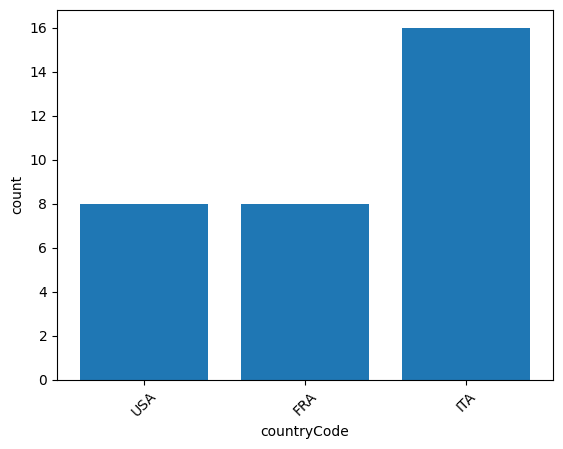

In [408]:
res_.bar();

The main strength of Relational DBs is the possibility of matching information from different tables though **Join** operations.

A join, either performed explicitely or implicitely is:

Just remember:
1. Computationally expensive. In case of large databases group by operations might require a long time to execute
2. Very easy to be done wrong, thus resulting in non-meaningful results

Be sure on which attributes (most often keys) you are performing a join operation.

- Join the `supplier_to_product` table with the `suppliers` table 

In [409]:
%%sql

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
supplierID,int,NO,PRI,None,auto_increment
supplierName,varchar(30),NO,,,
countryCode,char(3),NO,,ITA,
email,varchar(30),NO,,None,


In [410]:
%%sql

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
prodID,int,NO,PRI,None,
supID,int,NO,PRI,None,


In [411]:
%%sql

SELECT *
FROM suppliers, supplier_to_product
WHERE suppliers.supplierID = supplier_to_product.supID;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,1,2
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,3,2
3,Wild Hops,ITA,myemail@wildhops.it,1,3
3,Wild Hops,ITA,myemail@wildhops.it,2,3
3,Wild Hops,ITA,myemail@wildhops.it,3,3
3,Wild Hops,ITA,myemail@wildhops.it,5,3
4,Beer Paradise,ITA,beer@beerparadise.it,2,4
4,Beer Paradise,ITA,beer@beerparadise.it,5,4


In [412]:
%%sql

SELECT *
FROM suppliers
INNER JOIN supplier_to_product ON suppliers.supplierID = supplier_to_product.supID;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,1,2
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,3,2
3,Wild Hops,ITA,myemail@wildhops.it,1,3
3,Wild Hops,ITA,myemail@wildhops.it,2,3
3,Wild Hops,ITA,myemail@wildhops.it,3,3
3,Wild Hops,ITA,myemail@wildhops.it,5,3
4,Beer Paradise,ITA,beer@beerparadise.it,2,4
4,Beer Paradise,ITA,beer@beerparadise.it,5,4


In [413]:
%%sql

SELECT *
FROM suppliers
LEFT JOIN supplier_to_product ON suppliers.supplierID = supplier_to_product.supID;

 * mysql+mysqlconnector://root:***@db
38 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,1,2
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,3,2
3,Wild Hops,ITA,myemail@wildhops.it,1,3
3,Wild Hops,ITA,myemail@wildhops.it,2,3
3,Wild Hops,ITA,myemail@wildhops.it,3,3
3,Wild Hops,ITA,myemail@wildhops.it,5,3
4,Beer Paradise,ITA,beer@beerparadise.it,2,4
4,Beer Paradise,ITA,beer@beerparadise.it,5,4


In [414]:
%%sql

SELECT *
FROM suppliers
RIGHT JOIN supplier_to_product ON suppliers.supplierID = supplier_to_product.supID;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,1,2
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,3,2
3,Wild Hops,ITA,myemail@wildhops.it,1,3
3,Wild Hops,ITA,myemail@wildhops.it,2,3
3,Wild Hops,ITA,myemail@wildhops.it,3,3
3,Wild Hops,ITA,myemail@wildhops.it,5,3
4,Beer Paradise,ITA,beer@beerparadise.it,2,4
4,Beer Paradise,ITA,beer@beerparadise.it,5,4


We can concatenate multiple join operations to extract higher level information out of the connections stored in the DB

- Add the corresponding product names the the previous join

In [415]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,int,NO,PRI,None,auto_increment
productName,varchar(30),NO,,,
unitPrice,float,NO,,100000,
unitsInStock,int unsigned,NO,,0,
isDiscontinued,tinyint(1),NO,,0,


In [416]:
%%sql

SELECT *
FROM supplier_to_product
INNER JOIN suppliers ON suppliers.supplierID = supplier_to_product.supID
INNER JOIN products  ON products.productID   = supplier_to_product.prodID;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


prodID,supID,supplierID,supplierName,countryCode,email,productID,productName,unitPrice,unitsInStock,isDiscontinued
2,1,1,A hop in the park,USA,anewemail@ahop.com,2,Punk IPA,5.2,45,0
3,1,1,A hop in the park,USA,anewemail@ahop.com,3,HB Dunkel,4.5,250,0
1,2,2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,1,Founders Porter,4.9,12,0
3,2,2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,3,HB Dunkel,4.5,250,0
1,3,3,Wild Hops,ITA,myemail@wildhops.it,1,Founders Porter,4.9,12,0
2,3,3,Wild Hops,ITA,myemail@wildhops.it,2,Punk IPA,5.2,45,0
3,3,3,Wild Hops,ITA,myemail@wildhops.it,3,HB Dunkel,4.5,250,0
5,3,3,Wild Hops,ITA,myemail@wildhops.it,5,Damm Complot,3.7,120,0
2,4,4,Beer Paradise,ITA,beer@beerparadise.it,2,Punk IPA,5.2,45,0
5,4,4,Beer Paradise,ITA,beer@beerparadise.it,5,Damm Complot,3.7,120,0


The conjunction of `SELECT`, `GROUP BY` and `JOIN` statements will allow us to extract non trivial information out of any Relational DB.

Add the following records to the `supplier_to_product` table and perform the following queries:
    
| supplier | products provided |
| --- | --- | 
| "Wild Hops" | "Founders Porter", "Punk IPA", "HB Dunkel", "Damm Complot" |    
| "Beer Paradise" | "Punk IPA", "Damm Complot" |    
| "Allez Hops! Cave à bièr" | "Founders Porter", "HB Dunkel" |    

1. show all suppliers of "Damm Complot"
2. retrieve the email address of all possible suppliers of "Punk IPA"
3. list the unit price of all products supplied by Italian firms, listed in descending order   

In [417]:
sql_ = "INSERT INTO supplier_to_product (prodID, supID) VALUES (%s, %s)"
val_ = [
    # supplier Allez Hops
    (1, 2),
    (3, 2),

    # supplier Wild Hops
    (1, 3),
    (2, 3),
    (3, 3),
    (5, 3),

    # supplier Beer Paradise
    (2, 4),
    (5, 4),
]


dbc.executemany(sql_, val_)
db.commit()
     
dbc.execute("SELECT * FROM supplier_to_product"); 
for _ in dbc:
     print(_)

IntegrityError: 1062 (23000): Duplicate entry '1-2' for key 'supplier_to_product.PRIMARY'

#### 1 - show all suppliers of "Damm Complot"

In [418]:
%%sql

SELECT suppliers.supplierName
FROM supplier_to_product
INNER JOIN suppliers ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID
WHERE products.productName = "Damm Complot";

 * mysql+mysqlconnector://root:***@db
2 rows affected.


supplierName
Wild Hops
Beer Paradise


#### 2 - retrieve the email address of all possible suppliers of "Punk IPA"

In [419]:
%%sql

SELECT suppliers.email 
FROM supplier_to_product
INNER JOIN suppliers ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID
WHERE products.productName = "Punk IPA";

 * mysql+mysqlconnector://root:***@db
3 rows affected.


email
anewemail@ahop.com
myemail@wildhops.it
beer@beerparadise.it


In [420]:
%%sql 

SELECT *
FROM products;

 * mysql+mysqlconnector://root:***@db
32 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0
6,Founders Porter,4.9,12,0
7,Punk IPA,5.2,45,0
8,HB Dunkel,4.5,250,0
10,Damm Complot,3.7,120,0
11,Founders Porter,4.9,12,0
12,Punk IPA,5.2,45,0


In [421]:
%%sql 

SELECT *
FROM supplier_to_product;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


prodID,supID
2,1
3,1
1,2
3,2
1,3
2,3
3,3
5,3
2,4
5,4


In [422]:
%%sql 

SELECT *
FROM suppliers;

 * mysql+mysqlconnector://root:***@db
32 rows affected.


supplierID,supplierName,countryCode,email
1,A hop in the park,USA,anewemail@ahop.com
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com
3,Wild Hops,ITA,myemail@wildhops.it
4,Beer Paradise,ITA,beer@beerparadise.it
5,A hop in the park,USA,anewemail@ahop.com
6,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com
7,Wild Hops,ITA,myemail@wildhops.it
8,Beer Paradise,ITA,beer@beerparadise.it
9,A hop in the park,USA,anewemail@ahop.com
10,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com


#### 3 - list the unit price of all products supplied by Italian firms, listed in descending order   

In [423]:
%%sql

SELECT DISTINCT products.unitPrice, products.productName
FROM supplier_to_product
INNER JOIN suppliers ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID
WHERE suppliers.countryCode = "ITA"
ORDER BY unitPrice DESC;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


unitPrice,productName
5.2,Punk IPA
4.9,Founders Porter
4.5,HB Dunkel
3.7,Damm Complot


In [424]:
#%% sql
# CREATE DATABASE world

#docker exc -it mysql -db-l hash 

## 05 Queries on well-formed DBs

In MySQL we can load entire DBs from external files.

The files will contain the full DB structure (tables and constraints) and will populate all tables with all records 

To load a DB into the MySQL server from the interactive docker shell, we can simply do the following:

1. Create a new DB named `world`
2. Import the content of the file `/mapd-workspace/dbs/world.sql` into the newly created DB via
    
```bash
$ mysql -u root -p world < /mapd-workspace/dbs/world.sql
```

_NB_: The `opt/workspace` directory has been defined as a Docker Volume, and is a shared location with your computer...

Using the `world` DB, perform queries to answer the folliwing questions.

Additional references can be found here https://dev.mysql.com/doc/world-setup/en/


Use a single query to answer the questions

1. Which country has the largest population?
2. Get the total number of cities in Canada.
3. Select the country with the most cities.
4. List all the languages spoken in the Southeast Asia region.
5. Identify the 5 most spoken language by number of countries.
6. What is the total population of the cities in the Caribbean region?
7. What Countries have a City named "Kingston"?
8. Plot the population density by country, limiting to the 25 with least density.
9. Plot the GNP (Gross Nation Product) of all countries that become independent between 1850 and 1910, limiting to the 10 with highest GNP.
10. Create a scatter plot of the life expentency vs the GNP of all countries that have Spanish as their Official language.


Suggestions:
- Start by inspecting the DB tables structure
- When in doubt, check the table content by selecting a few lines (use `LIMIT` to avoid returining all records)
- Before finalizing the query, you can always perform "intermediate" queries to check if complex operations (groupby and join mostly) are stated correctly

In [697]:
%%sql

USE world; 

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
0 rows affected.
3 rows affected.


Tables_in_world
city
country
countrylanguage


In [434]:
%%sql

DESCRIBE city;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
ID,int,NO,PRI,None,auto_increment
Name,char(35),NO,,,
CountryCode,char(3),NO,MUL,,
District,char(20),NO,,,
Population,int,NO,,0,


#### 1 - Which country has the largest population?

In [433]:
%%sql
SELECT *
FROM country
ORDER BY Population DESC
LIMIT 1;


 * mysql+mysqlconnector://root:***@db
1 rows affected.


Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
CHN,China,Asia,Eastern Asia,9572900.00,-1523,1277558000,71.4,982268.00,917719.00,Zhongquo,People'sRepublic,Jiang Zemin,1891,CN


#### 2 - Get the total number of cities in Canada.

In [ ]:
%%sql
DESCRIBE countrylanguage;

In [698]:
%%sql 

SELECT CountryCode, COUNT(CountryCode) AS CitiesInCanada
FROM city
WHERE (CountryCode = "CAN")
GROUP BY CountryCode;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


CountryCode,CitiesInCanada
CAN,49


#### 3 - Select the country with the most cities.

In [ ]:
%%sql 
SELECT countrycode, COUNT(countrycode) AS mostcities
FROM city
GROUP BY countrycode
ORDER BY mostcities DESC
LIMIT 1;

#### 4 - List all the languages spoken in the 'Southeast Asia' region.

In [446]:
%%sql 
DESCRIBE countrylanguage;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
CountryCode,char(3),NO,PRI,,
Language,char(30),NO,PRI,,
IsOfficial,"enum('T','F')",NO,,F,
Percentage,"decimal(4,1)",NO,,0.0,


In [447]:
%%sql 
DESCRIBE country;

 * mysql+mysqlconnector://root:***@db
15 rows affected.


Field,Type,Null,Key,Default,Extra
Code,char(3),NO,PRI,,
Name,char(52),NO,,,
Continent,"enum('Asia','Europe','North America','Africa','Oceania','Antarctica','South America')",NO,,Asia,
Region,char(26),NO,,,
SurfaceArea,"decimal(10,2)",NO,,0.00,
IndepYear,smallint,YES,,None,
Population,int,NO,,0,
LifeExpectancy,"decimal(3,1)",YES,,None,
GNP,"decimal(10,2)",YES,,None,
GNPOld,"decimal(10,2)",YES,,None,


In [452]:
%%sql
SELECT DISTINCT countrylanguage.language
FROM country
INNER JOIN countrylanguage ON country.code=countrylanguage.countrycode
WHERE(country.Region= "Southeast Asia")
ORDER BY countrylanguage.language DESC;

 * mysql+mysqlconnector://root:***@db
47 rows affected.


language
Waray-waray
Vietnamese
Tšam
Tho
Thai
Tamil
Sunda
Shan
Rakhine
Portuguese


In [ ]:
%%sql 
DESCRIBE countrylanguage;

In [ ]:
%%sql

SELECT DISTINCT countrylanguage.Language
FROM country
INNER JOIN  countrylanguage  ON country.Code=countrylanguage.countryCode
WHERE country.Region="Southeast Asia"
ORDER BY countrylanguage.Language  ASC ;

#### 5 - Identify the 5 most spoken language by number of countries.

In [ ]:
%%sql 

DESCRIBE countrylanguage;

In [459]:
%%sql

SELECT language, COUNT(language) AS mostspoken
FROM countrylanguage
GROUP BY language
ORDER BY mostspoken DESC
LIMIT 5;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


language,mostspoken
English,60
Arabic,33
Spanish,28
French,25
German,19


#### 6 - What is the total population of the cities in the Caribbean region?

In [ ]:
%%sql

SELECT *
FROM country
WHERE (region="Caribbean");

In [ ]:
%%sql

SELECT *
FROM city;

In [475]:
%%sql

SELECT DISTINCT city.population,city.countrycode,country.region
FROM city
LEFT JOIN  country ON city.countrycode=country.code
WHERE (country.region="Caribbean") ;

 * mysql+mysqlconnector://root:***@db
58 rows affected.


population,countrycode,region
29034,ABW,Caribbean
961,AIA,Caribbean
595,AIA,Caribbean
2345,ANT,Caribbean
24000,ATG,Caribbean
172000,BHS,Caribbean
6070,BRB,Caribbean
2256000,CUB,Caribbean
433180,CUB,Caribbean
298726,CUB,Caribbean


#### 7 - What Countries have a City named "Kingston"?

In [ ]:
%%sql
DESCRIBE city;

In [ ]:
%%sql

SELECT DISTINCT country.code,country.name,city.name
FROM country
RIGHT JOIN  city ON country.code= city.countrycode
WHERE (city.name= "Kingston") ;

#### 8 - Plot the population density by country, limiting to the 25 with least density.

In [479]:
%%sql
SELECT DISTINCT (Population/Surfacearea) AS Density, name
FROM country
ORDER BY Density ASC
LIMIT 25;

 * mysql+mysqlconnector://root:***@db
25 rows affected.


Density,name
0.0000,Antarctica
0.0000,Bouvet Island
0.0000,British Indian Ocean Territory
0.0000,French Southern territories
0.0000,Heard Island and McDonald Islands
0.0000,South Georgia and the South Sandwich Islands
0.0000,United States Minor Outlying Islands
0.0259,Greenland
0.0513,Svalbard and Jan Mayen
0.1643,Falkland Islands


 * mysql+mysqlconnector://root:***@db
25 rows affected.
+------+---------+
| code | density |
+------+---------+
| UMI  |  0.0000 |
| IOT  |  0.0000 |
| HMD  |  0.0000 |
| SGS  |  0.0000 |
| BVT  |  0.0000 |
| ATF  |  0.0000 |
| ATA  |  0.0000 |
| GRL  |  0.0259 |
| SJM  |  0.0513 |
| FLK  |  0.1643 |
| PCN  |  1.0204 |
| ESH  |  1.1015 |
| MNG  |  1.6993 |
| GUF  |  2.0111 |
| NAM  |  2.0939 |
| AUS  |  2.4397 |
| SUR  |  2.5541 |
| MRT  |  2.6036 |
| ISL  |  2.7087 |
| BWA  |  2.7882 |
| CAN  |  3.1239 |
| LBY  |  3.1855 |
| GUY  |  4.0052 |
| GAB  |  4.5803 |
| CAF  |  5.8027 |
+------+---------+


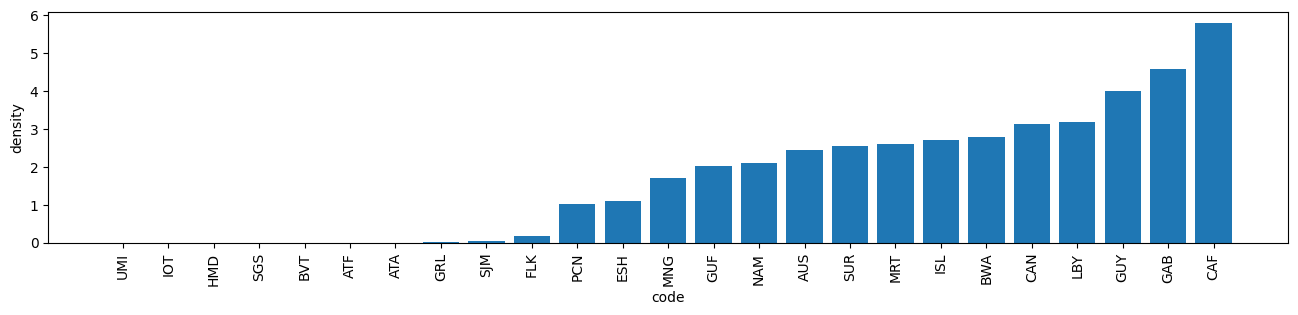

In [480]:
res_ = %sql SELECT  code, population/surfacearea AS density   FROM country    ORDER BY density ASC       LIMIT 25;

print(res_)

plt.figure(figsize=(16,3))
res_.bar();
plt.xticks(rotation='vertical');

#### 9 - Plot the GNP (Gross Nation Product) of all countries that become independent between 1850 and 1910, limiting to the 10 with highest GNP.

In [481]:
%%sql
DESCRIBE country

 * mysql+mysqlconnector://root:***@db
15 rows affected.


Field,Type,Null,Key,Default,Extra
Code,char(3),NO,PRI,,
Name,char(52),NO,,,
Continent,"enum('Asia','Europe','North America','Africa','Oceania','Antarctica','South America')",NO,,Asia,
Region,char(26),NO,,,
SurfaceArea,"decimal(10,2)",NO,,0.00,
IndepYear,smallint,YES,,None,
Population,int,NO,,0,
LifeExpectancy,"decimal(3,1)",YES,,None,
GNP,"decimal(10,2)",YES,,None,
GNPOld,"decimal(10,2)",YES,,None,


In [ ]:
%%sql
DESCRIBE countrylanguage;


 * mysql+mysqlconnector://root:***@db
10 rows affected.
+--------------+------------+
|     name     |    GNP     |
+--------------+------------+
|    Italy     | 1161755.00 |
|    Canada    | 598862.00  |
|  Australia   | 351182.00  |
|     Iran     | 195746.00  |
|    Norway    | 145895.00  |
| South Africa | 116729.00  |
| New Zealand  |  54669.00  |
|   Romania    |  38158.00  |
|     Cuba     |  17843.00  |
|  Luxembourg  |  16321.00  |
+--------------+------------+


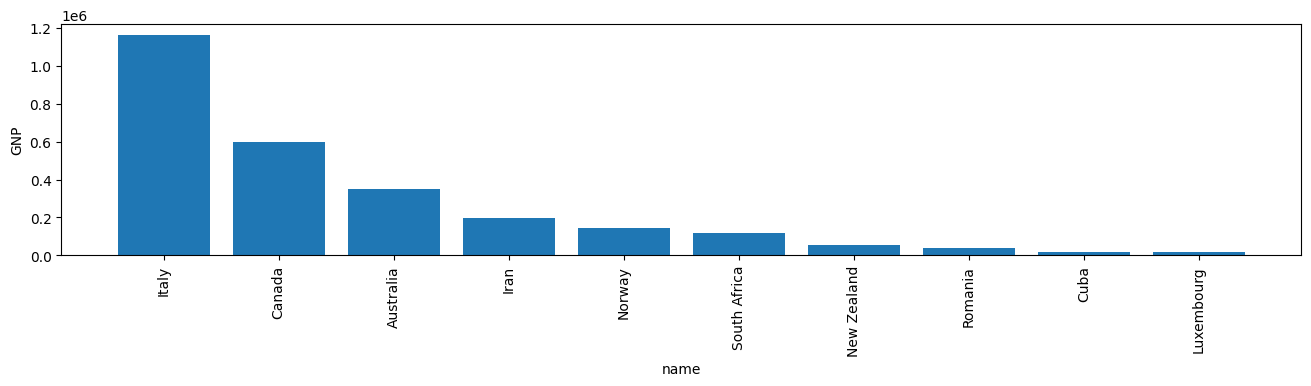

In [484]:
res_ = %sql SELECT name, GNP     FROM   country   WHERE (IndepYear BETWEEN 1850 AND 1910)     ORDER BY   GNP DESC LIMIT 10 ;

print(res_)

plt.figure(figsize=(16,3))
res_.bar();
plt.xticks(rotation='vertical');

#### 10 - Create a scatter plot of the life expentency vs the GNP of all countries that have Spanish as their Official language.

In [485]:
%%sql
DESCRIBE countrylanguage

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
CountryCode,char(3),NO,PRI,,
Language,char(30),NO,PRI,,
IsOfficial,"enum('T','F')",NO,,F,
Percentage,"decimal(4,1)",NO,,0.0,


In [487]:
%%sql
SELECT country.LifeExpectancy , country.GNP, countrylanguage.language
FROM country
INNER JOIN countrylanguage ON country.code= countrylanguage.countrycode
WHERE( countrylanguage.language = "Spanish") AND countrylanguage.IsOfficial = "T"

 * mysql+mysqlconnector://root:***@db
20 rows affected.


LifeExpectancy,GNP,language
75.1,340238.00,Spanish
63.7,8571.00,Spanish
75.7,72949.00,Spanish
70.3,102896.00,Spanish
75.8,10226.00,Spanish
76.2,17843.00,Spanish
73.2,15846.00,Spanish
71.1,19770.00,Spanish
78.8,553233.00,Spanish
66.2,19008.00,Spanish


In [ ]:
res_ = %sql SELECT  DISTINCT country.LifeExpectancy ,country.gnp, country.name\
            FROM countrylanguage \
            RIGHT JOIN  country  ON country.code=countrylanguage.countrycode  \
            WHERE (countrylanguage.language = "Spanish")\
             AND countrylanguage.IsOfficial = "T" ;

print(res_)

plt.figure(figsize=(8,6))
for _ in res_:
    plt.scatter(_[0],_[1],s=50);
    plt.annotate(_[2], (float(_[0])*1.002,float(_[1])*1.002));
plt.ylabel('GNP')
plt.xlabel('LifeExpectancy')


## 06 More on queries 

Let' import a well-structured DB, with several tables and relationships, to be used as a sandbox for further exercises on queries.

The `.sql` file can be found at: `/mapd-workspace/dbs/IMDb_pruned.sql`.

The DB is freely available and is taken from the IMDb (Internet Movie Database) website (https://www.imdb.com/interfaces/).

The entire database is composed of a dozen of tables, hosing all people involved in Movies, Shorts, TV Show Epidoses and more since the 1890s. 

To simplify the execution of queries, we will work with a slimmed-down version of the entire DB, with still plenty of records for us to extract interesting information.

1. Create a new DB named `IMDb`
2. Import the content of the file `/mapd-workspace/dbs/IMDb_pruned.sql` into the newly created DB
(this might take a minute or two...)

### Check which tables are available

In [692]:
%%sql 

USE IMDb_pruned;

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
0 rows affected.
13 rows affected.


Tables_in_IMDb_pruned
Directors
Episode_belongs_to
Had_role
Names_
Title_genres
Title_ratings
Titles
bla
blaa
blabla


### Describe the content of table Names_

In [489]:
%%sql 
DESCRIBE Names_;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
name_id,varchar(255),NO,,None,
name_,varchar(255),NO,,None,
birth_year,smallint,YES,,None,
death_year,smallint,YES,,None,


### People by birth year

A) Start by limiting the query to 1000 entries

1. Draw an histogram of the year of birth
2. Draw a second histogram with the year of birth of the 1000 youngest people in the list

In [699]:
%%sql 
SELECT birth_year 
FROM Names_ 
LIMIT 1000;

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1146 (42S02): Table 'world.Names_' doesn't exist
[SQL: SELECT birth_year 
FROM Names_ 
LIMIT 1000;]
(Background on this error at: https://sqlalche.me/e/14/f405)


In [ ]:
import numpy as np

res=%sql SELECT birth_year FROM Names_ LIMIT 1000;
# convertiamo il risultato della query in un array NumPy
birth_years = np.array(res)

# plottiamo l'istogramma
plt.hist(birth_years)
plt.xlabel('Anni di nascita')
plt.ylabel('Frequenza')
plt.show()

In [ ]:

%%sql 
SELECT birth_year 
FROM Names_ 
ORDER BY birth_year DESC
LIMIT 1000;

 * mysql+mysqlconnector://root:***@db
1000 rows affected.


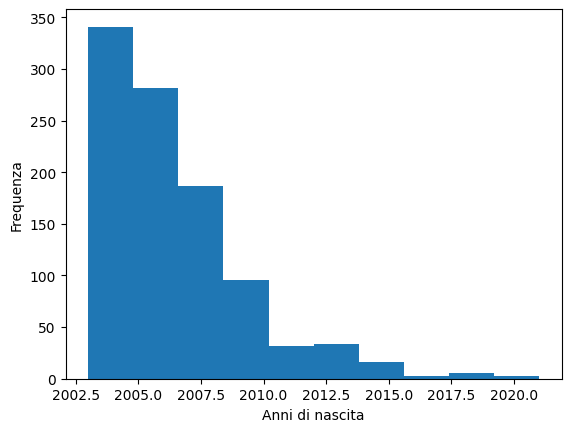

In [493]:
young=%sql SELECT birth_year FROM Names_ ORDER BY birth_year DESC LIMIT 1000;
# convertiamo il risultato della query in un array NumPy
birth_years = np.array(young)

# plottiamo l'istogramma
plt.hist(birth_years)
plt.xlabel('Anni di nascita')
plt.ylabel('Frequenza')
plt.show()

B) Extend the query to all records in the table

1. Check for outliers (inspect min and max)
2. If any outlier is found, limit the query to a reasonable range (at least people born after 1850)
3. Draw a new histogram with the year of birth
4. Compute the mean and std of year of birth

In [ ]:
%%sql
SELECT MAX(birth_year),MIN(birth_year)
FROM Names_;


In [497]:
%%sql

SELECT COUNT(*),MIN(birth_year),MAX(birth_year) 
FROM Names_ 
WHERE (birth_year < 1850);

 * mysql+mysqlconnector://root:***@db
1 rows affected.


COUNT(*),MIN(birth_year),MAX(birth_year)
2,13,1088


In [ ]:
outlier= %sql SELECT birth_year FROM Names_ WHERE(birth_year>1850)
# convertiamo il risultato della query in un array NumPy
birth_years = np.array(outlier)

# plottiamo l'istogramma
plt.hist(birth_years,bins=50)
plt.xlabel('Anni di nascita')
plt.ylabel('Frequenza')
plt.show()

In [ ]:
%%sql
SELECT AVG(birth_year), STD(birth_year)
FROM Names_
WHERE (birth_year > 1850);

### Movie stats

1. Plot how many titles can be found in the DB per year, over the past 25 years
2. List the names of all actors who have had the role of Spider-Man and the corresponding Title
3. List and count the 10 people who appeared the most in movies by "Wes Anderson"

In [519]:
%%sql
DESCRIBE Titles;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
title_type,varchar(50),YES,,None,
primary_title,text,YES,,None,
start_year,int,YES,,None,
runtime_minutes,int,YES,,None,


In [520]:
%%sql
DESCRIBE Names_

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
name_id,varchar(255),NO,,None,
name_,varchar(255),NO,,None,
birth_year,smallint,YES,,None,
death_year,smallint,YES,,None,


In [521]:
%%sql
DESCRIBE Had_role

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
name_id,varchar(255),NO,,None,
role_,text,NO,,None,


In [522]:
%%sql
DESCRIBE Directors

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
name_id,varchar(255),NO,,None,


#### 1 - Plot how many titles can be found in the DB per year, over the past 25 years

In [35]:
%%sql
USE IMDb_pruned;

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
0 rows affected.
7 rows affected.


Tables_in_IMDb_pruned
Directors
Episode_belongs_to
Had_role
Names_
Title_genres
Title_ratings
Titles


In [36]:
%%sql

DESCRIBE Titles;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
title_type,varchar(50),YES,,None,
primary_title,text,YES,,None,
start_year,int,YES,,None,
runtime_minutes,int,YES,,None,


In [37]:
%%sql
SELECT COUNT(primary_title) AS titlesoverthepast25years
FROM Titles
WHERE(start_year >1998);

 * mysql+mysqlconnector://root:***@db
1 rows affected.


titlesoverthepast25years
885462


In [38]:
%%sql 
SELECT COUNT(primary_title) AS numbertitles, start_year
FROM Titles
WHERE(start_year >1998)
GROUP BY start_year
ORDER BY start_year DESC
LIMIT 5;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


numbertitles,start_year
1,2027
3,2026
4,2025
14,2024
161,2023


In [39]:
plottitle=%sql SELECT COUNT(primary_title) AS numbertitles, start_year FROM Titles WHERE(start_year >1998) GROUP BY start_year ORDER BY start_year DESC;

 * mysql+mysqlconnector://root:***@db
29 rows affected.


In [40]:
import pandas as pd
plottilte=np.array(plottitle)
df = pd.DataFrame(plottilte)
df
# plotta il DataFrame
df.columns = ["number", "years"]
df
plt.plot( df.years,df.number)
# aggiungi etichette agli assi e un titolo al grafico
plt.xlabel('x')
plt.ylabel('y')
plt.title('Grafico di esempio')
# mostra il grafico
plt.show()

NameError: name 'np' is not defined

#### 2 - List the names of all actors who have had the role of Spider-Man and the corresponding Title 

In [41]:
%%sql

DESCRIBE Had_role;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
name_id,varchar(255),NO,,None,
role_,text,NO,,None,


In [42]:
%%sql

DESCRIBE Names_;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
name_id,varchar(255),NO,,None,
name_,varchar(255),NO,,None,
birth_year,smallint,YES,,None,
death_year,smallint,YES,,None,


In [43]:
%%sql

DESCRIBE Titles;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
title_type,varchar(50),YES,,None,
primary_title,text,YES,,None,
start_year,int,YES,,None,
runtime_minutes,int,YES,,None,


In [44]:
%%sql 

SELECT Names_.name_, Titles.primary_title, Titles.title_type, Titles.start_year
FROM Had_role 
INNER JOIN Titles ON Had_role.title_id = Titles.title_id
INNER JOIN Names_ ON Had_role.name_id = Names_.name_id
WHERE (Had_role.role_ = "Spider-Man")
ORDER BY Names_.name_, Titles.primary_title;


 * mysql+mysqlconnector://root:***@db
310 rows affected.


name_,primary_title,title_type,start_year
Aaron Schoenke,Spider-Man vs. Darth Maul,tvEpisode,2015
Andrew Garfield,The Amazing Spider-Man,movie,2012
Andrew Garfield,The Amazing Spider-Man 2,movie,2014
Andy Richter,Major League of Extraordinary Gentlemen,tvEpisode,2011
Christopher Daniel Barnes,Day of the Chameleon,tvEpisode,1995
Christopher Daniel Barnes,Doctor Octopus: Armed and Dangerous,tvEpisode,1995
Christopher Daniel Barnes,Kraven the Hunter,tvEpisode,1995
Christopher Daniel Barnes,Neogenic Nightmare Chapter 10: The Immortal Vampire,tvEpisode,1996
Christopher Daniel Barnes,Neogenic Nightmare Chapter 11: Tablet of Time,tvEpisode,1995
Christopher Daniel Barnes,Neogenic Nightmare Chapter 12: Ravages of Time,tvEpisode,1995


#### 3 - List and count the 10 people who appeared the most in movies by "Wes Anderson"

In [47]:
%%sql
DESCRIBE Title_genres;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
genre,varchar(255),NO,,None,


In [48]:
%%sql
SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
7 rows affected.


Tables_in_IMDb_pruned
Directors
Episode_belongs_to
Had_role
Names_
Title_genres
Title_ratings
Titles


In [49]:
%%sql
DESCRIBE Directors;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
name_id,varchar(255),NO,,None,


In [50]:
%%sql
SELECT *
FROM Directors
LIMIT 1;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


title_id,name_id
tt0035423,nm0003506


In [51]:
%%sql
SELECT *
FROM Names_
WHERE(name_ LIKE "Wes Anderson");

 * mysql+mysqlconnector://root:***@db
1 rows affected.


name_id,name_,birth_year,death_year
nm0027572,Wes Anderson,1969,None


In [52]:
%%sql

SELECT *
FROM Directors
INNER JOIN Names_ ON Names_.name_id=Directors.name_id
WHERE(Names_.name_="Wes Anderson");

 * mysql+mysqlconnector://root:***@db
10 rows affected.


title_id,name_id,name_id_1,name_,birth_year,death_year
tt0115734,nm0027572,nm0027572,Wes Anderson,1969,None
tt0128445,nm0027572,nm0027572,Wes Anderson,1969,None
tt0265666,nm0027572,nm0027572,Wes Anderson,1969,None
tt0362270,nm0027572,nm0027572,Wes Anderson,1969,None
tt0432283,nm0027572,nm0027572,Wes Anderson,1969,None
tt0838221,nm0027572,nm0027572,Wes Anderson,1969,None
tt1748122,nm0027572,nm0027572,Wes Anderson,1969,None
tt2278388,nm0027572,nm0027572,Wes Anderson,1969,None
tt5104604,nm0027572,nm0027572,Wes Anderson,1969,None
tt8847712,nm0027572,nm0027572,Wes Anderson,1969,None


In [53]:
%%sql
SELECT  Had_role.title_id, Names_.name_
FROM Had_role
INNER JOIN Names_ ON Had_role.name_id=Names_.name_id
WHERE(Had_role.title_id IN (
      SELECT Directors.title_id 
      FROM Directors
      INNER JOIN Names_ ON Names_.name_id=Directors.name_id
      WHERE(Names_.name_="Wes Anderson")
)
     );

 * mysql+mysqlconnector://root:***@db
39 rows affected.


title_id,name_
tt0432283,George Clooney
tt2278388,Ralph Fiennes
tt1748122,Bill Murray
tt0432283,Bill Murray
tt0362270,Bill Murray
tt0128445,Bill Murray
tt1748122,Bruce Willis
tt0265666,Gene Hackman
tt0265666,Gwyneth Paltrow
tt0432283,Meryl Streep


In [72]:
%%sql
SELECT  COUNT(Names_.name_) AS number,Names_.name_
FROM Had_role
INNER JOIN Names_ ON Had_role.name_id=Names_.name_id
WHERE(Had_role.title_id IN(SELECT Directors.title_id
FROM Directors
INNER JOIN Names_ ON Names_.name_id=Directors.name_id
WHERE(Names_.name_="Wes Anderson")))
GROUP BY Names_.name_
ORDER BY number DESC
LIMIT 10;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


number,name_
4,Bill Murray
3,Owen Wilson
3,Jason Schwartzman
3,Adrien Brody
2,Anjelica Huston
1,Ralph Fiennes
1,Kara Hayward
1,Gene Hackman
1,Gwyneth Paltrow
1,F. Murray Abraham


### Is the IMDB only about movies? 

1. Check the number of different media types contained in the DB
2. Plot an histogram about the number of media types per group
3. Find the name and rating of the oldest videogame stored in the DB 

#### 1 - Check the number of different media types contained in the DB

In [702]:
%%sql
USE IMDb_pruned;

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
0 rows affected.
13 rows affected.


Tables_in_IMDb_pruned
Directors
Episode_belongs_to
Had_role
Names_
Title_genres
Title_ratings
Titles
bla
blaa
blabla


In [703]:
%%sql
DESCRIBE Title_genres;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
genre,varchar(255),NO,,None,


In [704]:
%%sql
DESCRIBE Titles;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
title_type,varchar(50),YES,,None,
primary_title,text,YES,,None,
start_year,int,YES,,None,
runtime_minutes,int,YES,,None,


In [705]:
%%sql
SELECT COUNT(title_type) AS mediatype,title_type
FROM Titles
GROUP BY title_type
ORDER BY mediatype DESC;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


mediatype,title_type
708598,tvEpisode
239353,movie
59424,tvSeries
11963,tvMiniSeries
257,videoGame


#### 2 - Plot an histogram about the number of media types per group

 * mysql+mysqlconnector://root:***@db
1019595 rows affected.


(array([2.39353e+05, 0.00000e+00, 7.08598e+05, 0.00000e+00, 0.00000e+00,
        5.94240e+04, 0.00000e+00, 1.19630e+04, 0.00000e+00, 2.57000e+02]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

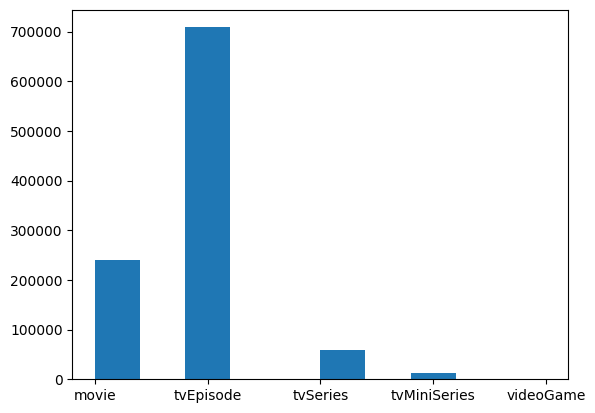

In [706]:
import numpy as np
media=%sql SELECT title_type FROM Titles;


# convertiamo il risultato della query in un array NumPy
media = np.array(media)

plt.hist(media)

#### 3 - Find the name and rating of the oldest videogame stored in the DB 

In [707]:
%%sql
DESCRIBE Title_ratings;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
average_rating,float,YES,,None,
num_votes,int,YES,,None,


In [708]:
%%sql
DESCRIBE Titles;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
title_type,varchar(50),YES,,None,
primary_title,text,YES,,None,
start_year,int,YES,,None,
runtime_minutes,int,YES,,None,


In [709]:
%%sql
SELECT MIN(start_year)
FROM Titles;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


MIN(start_year)
1990


In [710]:
%%sql
SELECT Titles.primary_title, Title_ratings.average_rating, Titles.start_year
FROM Titles
INNER JOIN Title_ratings ON Title_ratings.title_id=Titles.title_id
WHERE Titles.title_type LIKE "videoGame"
ORDER BY Titles.start_year ASC
LIMIT 1;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


primary_title,average_rating,start_year
Lord of the Rings,6.9,1990


### Identify interesting outliers 

1. List the names of movies whose title begin with "The" have a runtime between 3 and 4 hours.
2. What actor had the most roles as 'Self'?
3. Identify what TV series had more than 1,000 episodes, and check the first- and last-episod year

In [711]:
%%sql
DESCRIBE  Episode_belongs_to;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
episode_title_id,varchar(255),NO,,None,
parent_tv_show_title_id,varchar(255),NO,,None,
season_number,int,YES,,None,
episode_number,int,YES,,None,


In [712]:
%%sql
SELECT COUNT(Titles.title_id) AS count , Titles.title_id
FROM Titles
INNER JOIN Episode_belongs_to ON Episode_belongs_to.parent_tv_show_title_id=Titles.title_id
WHERE (Titles.title_type = "tvSeries") 
GROUP BY Titles.title_id
HAVING count >1000
LIMIT 25;

 * mysql+mysqlconnector://root:***@db
25 rows affected.


count,title_id
6550,tt0096597
3856,tt0098911
1225,tt0103396
7455,tt0103434
3983,tt0103487
4642,tt0103569
2778,tt0106052
6691,tt0106053
2558,tt0106113
2759,tt0108821


In [713]:
%%sql 
SELECT 

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1064 (42000): You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near '' at line 1
[SQL: SELECT]
(Background on this error at: https://sqlalche.me/e/14/f405)


In [714]:
%%sql 
SELECT 

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1064 (42000): You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near '' at line 1
[SQL: SELECT]
(Background on this error at: https://sqlalche.me/e/14/f405)


#### 1 - List the names of movies whose title begin with "The" have a runtime between 3 and 4 hours.

In [715]:
%%sql

SELECT primary_title,runtime_minutes/60
FROM Titles
WHERE( runtime_minutes/60  BETWEEN 3 AND 4 ) AND primary_title LIKE "The%s" AND title_type LIKE "movie"
ORDER BY runtime_minutes/60 ASC ;

 * mysql+mysqlconnector://root:***@db
11 rows affected.


primary_title,runtime_minutes/60
The Best Intentions,3.0000
The Rake Creatures,3.0500
The Secret Fighting Arts of America: Expedition Highlights,3.2833
The Extincts,3.3333
The Battleships,3.4167
The Money Masters,3.5000
The History of Tanks,3.5833
The Furious Gods: Making Prometheus,3.6667
The Girl Who Picks Flowers and the Girl Who Kills Insects,3.9333
The Jim Breuer Road Journals,3.9500


#### 2 - What actor had the most roles as 'Self'?

In [716]:
%%sql
DESCRIBE Had_role;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
name_id,varchar(255),NO,,None,
role_,text,NO,,None,


In [717]:
%%sql
SELECT COUNT(name_) AS roleself,  name_
FROM Had_role
INNER JOIN Names_ ON Names_.name_id=Had_role.name_id
WHERE(Had_role.role_ = "Self")
GROUP BY name_
ORDER BY roleself DESC
LIMIT 1;

 * mysql+mysqlconnector://root:***@db
1 rows affected.


roleself,name_
3197,Scott Morrison


#### 3 - Identify what TV series had more than 1,000 episodes, and check the first- and last-episod year

In [718]:
%%sql
DESCRIBE  Episode_belongs_to;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
episode_title_id,varchar(255),NO,,None,
parent_tv_show_title_id,varchar(255),NO,,None,
season_number,int,YES,,None,
episode_number,int,YES,,None,


In [719]:
%%sql
SELECT *
FROM Episode_belongs_to
LIMIT 3;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


episode_title_id,parent_tv_show_title_id,season_number,episode_number
tt0088051,tt0974356,None,None
tt0088656,tt0088655,1,2
tt0088657,tt0088655,1,3


In [720]:
%%sql
DESCRIBE Titles;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
title_type,varchar(50),YES,,None,
primary_title,text,YES,,None,
start_year,int,YES,,None,
runtime_minutes,int,YES,,None,


In [721]:
%%sql
SELECT *
FROM Titles
LIMIT 3;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


title_id,title_type,primary_title,start_year,runtime_minutes
tt0011216,movie,Spanish Fiesta,2019,67
tt0015724,movie,Dama de noche,1993,102
tt0035423,movie,Kate & Leopold,2001,118


In [722]:
%%sql
DESCRIBE Title_genres;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
genre,varchar(255),NO,,None,


In [723]:
%%sql
DESCRIBE Had_role;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
name_id,varchar(255),NO,,None,
role_,text,NO,,None,


In [724]:
%%sql
SELECT COUNT(Episode_belongs_to.parent_tv_show_title_id) AS _, Episode_belongs_to.parent_tv_show_title_id, Titles.title_id
FROM Episode_belongs_to
INNER JOIN Titles ON Episode_belongs_to.parent_tv_show_title_id=Titles.title_id
GROUP BY parent_tv_show_title_id
HAVING _>1000
LIMIT 10;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


_,parent_tv_show_title_id,title_id
6550,tt0096597,tt0096597
3856,tt0098911,tt0098911
1225,tt0103396,tt0103396
7455,tt0103434,tt0103434
3983,tt0103487,tt0103487
4642,tt0103569,tt0103569
2778,tt0106052,tt0106052
6691,tt0106053,tt0106053
2558,tt0106113,tt0106113
2759,tt0108821,tt0108821


In [725]:
%%sql

CREATE VIEW new AS
SELECT COUNT(Episode_belongs_to.parent_tv_show_title_id) AS number, Episode_belongs_to.parent_tv_show_title_id
FROM Episode_belongs_to
GROUP BY parent_tv_show_title_id
HAVING number >1000
LIMIT 10;


 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1050 (42S01): Table 'new' already exists
[SQL: CREATE VIEW new AS
SELECT COUNT(Episode_belongs_to.parent_tv_show_title_id) AS number, Episode_belongs_to.parent_tv_show_title_id
FROM Episode_belongs_to
GROUP BY parent_tv_show_title_id
HAVING number >1000
LIMIT 10;]
(Background on this error at: https://sqlalche.me/e/14/f405)


In [204]:
%%sql
SELECT *
FROM new;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


number,parent_tv_show_title_id
6550,tt0096597
3856,tt0098911
1225,tt0103396
7455,tt0103434
3983,tt0103487
4642,tt0103569
2778,tt0106052
6691,tt0106053
2558,tt0106113
2759,tt0108821


In [739]:
%%sql
SELECT  Titles.title_id,MAX(Titles.start_year),MAX(Titles.start_year)
FROM new
INNER JOIN Titles ON new.parent_tv_show_title_id= Titles.title_id
GROUP BY Titles.title_id;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


title_id,MAX(Titles.start_year),MAX(Titles.start_year)_1
tt0096597,1990,1990
tt0098911,1992,1992
tt0103396,1992,1992
tt0103434,1992,1992
tt0103487,1992,1992
tt0103569,1992,1992
tt0106052,1993,1993
tt0106053,1993,1993
tt0106113,1992,1992
tt0108821,1991,1991


### It's all about the ratings 

1. Group all movies by decade and plot the rating distribution. Limit the query to the movies with at least 1000 ratings.
2. Plot the average rating of each episode of Games of Thrones. Group by season and compute the average and std for each season
3. Plot the total numer of movies per year, divided by genre (Action, Comedy, Drama, Thriller, Fantasy), and the yearly rating average per genre

In [675]:
%%sql
DESCRIBE Titles;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
title_type,varchar(50),YES,,None,
primary_title,text,YES,,None,
start_year,int,YES,,None,
runtime_minutes,int,YES,,None,


In [676]:
%%sql
DESCRIBE Episode_belongs_to;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
episode_title_id,varchar(255),NO,,None,
parent_tv_show_title_id,varchar(255),NO,,None,
season_number,int,YES,,None,
episode_number,int,YES,,None,


In [688]:
%%sql
DESCRIBE Title_genres;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
genre,varchar(255),NO,,None,


#### 1 - Group all movies by decade and plot the rating distribution. Limit the query to the movies with at least 1000 ratings.

In [236]:
%%sql
DESCRIBE Title_ratings;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
average_rating,float,YES,,None,
num_votes,int,YES,,None,


In [325]:
%%sql
SELECT SUM(Title_ratings.average_rating) AS Sumr,FLOOR(Titles.start_year/10)*10 AS decade
FROM Title_ratings
INNER JOIN Titles ON Title_ratings.title_id = Titles.title_id
WHERE Titles.title_type LIKE 'movie'
GROUP BY decade
ORDER BY decade;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Sumr,decade
114.5,None
125982.90000629425,1990
251052.100081563,2000
503590.40025150776,2010
82614.50004291534,2020


In [244]:
rate=%sql SELECT SUM(Title_ratings.average_rating) AS Sumr,FLOOR(Titles.start_year/10)*10 AS decade FROM Title_ratings INNER JOIN Titles ON Title_ratings.title_id = Titles.title_id WHERE Titles.title_type LIKE 'movie' GROUP BY decade LIMIT 4;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


In [249]:
import pandas as pd
plottilte=np.array(rate)
df = pd.DataFrame(rate)
df

,0,1
0,503590.400252,2010.0
1,125982.900006,1990.0
2,251052.100082,2000.0
3,82614.500043,2020.0


#### 2 - Plot the average rating of each episode of Games of Thrones. Group by season and compute the average and std for each season

In [278]:
%%sql
SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


Tables_in_IMDb_pruned
Directors
Episode_belongs_to
Had_role
Names_
Title_genres
Title_ratings
Titles
new
summ
summm


In [283]:
%%sql
DESCRIBE Episode_belongs_to;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
episode_title_id,varchar(255),NO,,None,
parent_tv_show_title_id,varchar(255),NO,,None,
season_number,int,YES,,None,
episode_number,int,YES,,None,


In [284]:
%%sql
DESCRIBE Had_role;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
name_id,varchar(255),NO,,None,
role_,text,NO,,None,


In [285]:
%%sql
DESCRIBE Names_;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
name_id,varchar(255),NO,,None,
name_,varchar(255),NO,,None,
birth_year,smallint,YES,,None,
death_year,smallint,YES,,None,


In [286]:
%%sql
DESCRIBE Titles;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
title_type,varchar(50),YES,,None,
primary_title,text,YES,,None,
start_year,int,YES,,None,
runtime_minutes,int,YES,,None,


In [314]:
%%sql
DESCRIBE Title_ratings;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
average_rating,float,YES,,None,
num_votes,int,YES,,None,


In [310]:
%%sql
SELECT *
FROM Titles
WHERE(primary_title LIKE "Winter is Coming");

 * mysql+mysqlconnector://root:***@db
1 rows affected.


title_id,title_type,primary_title,start_year,runtime_minutes
tt14005294,tvEpisode,Winter is Coming,2017,48


In [740]:
%%sql
SELECT Episode_belongs_to.season_number,Titles.primary_title,Episode_belongs_to.episode_number,Episode_belongs_to.episode_title_id,Title_ratings.average_rating
FROM Episode_belongs_to
INNER JOIN Titles ON Episode_belongs_to.parent_tv_show_title_id=Titles.title_id
INNER JOIN Title_ratings ON Title_ratings.title_id=Episode_belongs_to.episode_title_id
WHERE(Titles.primary_title LIKE "Game of Thrones")
ORDER BY Episode_belongs_to.season_number,  Episode_belongs_to.episode_number;

 * mysql+mysqlconnector://root:***@db
73 rows affected.


season_number,primary_title,episode_number,episode_title_id,average_rating
1,Game of Thrones,1,tt1480055,9.1
1,Game of Thrones,2,tt1668746,8.8
1,Game of Thrones,3,tt1829962,8.7
1,Game of Thrones,4,tt1829963,8.8
1,Game of Thrones,5,tt1829964,9.1
1,Game of Thrones,6,tt1837862,9.2
1,Game of Thrones,7,tt1837863,9.2
1,Game of Thrones,8,tt1837864,9.0
1,Game of Thrones,9,tt1851398,9.6
1,Game of Thrones,10,tt1851397,9.5


In [323]:
%%sql
SELECT AVG(Title_ratings.average_rating) AS average,STD(Title_ratings.average_rating) AS std,Episode_belongs_to.season_number 
FROM Episode_belongs_to
INNER JOIN Titles ON Episode_belongs_to.parent_tv_show_title_id=Titles.title_id
INNER JOIN Title_ratings ON Title_ratings.title_id=Episode_belongs_to.episode_title_id
WHERE(Titles.primary_title LIKE "Game of Thrones")
GROUP BY Episode_belongs_to.season_number;

 * mysql+mysqlconnector://root:***@db
8 rows affected.


average,std,season_number
9.100000095367431,0.279284841851893,1
8.960000038146973,0.3322648385598139,2
9.05,0.3905124105321288,3
9.310000038146972,0.3832752574106418,4
8.830000019073486,0.5273518051323894,5
9.05999984741211,0.588557477116479,6
9.099999972752162,0.37416567313687327,7
6.333333412806193,1.3634107864471021,8


#### 3 - Plot the total numer of movies per year, divided by genre (Action, Comedy, Drama, Thriller, Fantasy), and the yearly rating average per genre

In [326]:
%%sql
DESCRIBE Titles;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
title_type,varchar(50),YES,,None,
primary_title,text,YES,,None,
start_year,int,YES,,None,
runtime_minutes,int,YES,,None,


In [330]:
%%sql
DESCRIBE Title_genres;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
title_id,varchar(255),NO,,None,
genre,varchar(255),NO,,None,


In [557]:
%%sql
SELECT  Titles.start_year 
FROM Titles
WHERE(Titles.title_type LIKE "movie")
GROUP BY Titles.start_year 
ORDER BY Titles.start_year  DESC
LIMIT 5;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


start_year
2027
2026
2025
2024
2023


In [560]:
%%sql
 SELECT  COUNT(Titles.title_id) AS total, Title_genres.genre
FROM Titles
INNER JOIN Title_genres ON Title_genres.title_id=Titles.title_id
WHERE(Titles.title_type LIKE "movie")
GROUP BY Title_genres.genre
LIMIT 10;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


total,genre
92978,Drama
19590,Romance
8430,Mystery
6848,Fantasy
47279,Comedy
76746,Documentary
3920,Sport
20412,Action
2848,War
14584,Crime


In [572]:
%%sql
 SELECT  COUNT(Titles.title_id) AS total, Title_genres.genre, Titles.start_year, AVG(Title_ratings.average_rating)
FROM Titles
INNER JOIN Title_genres ON Title_genres.title_id=Titles.title_id
INNER JOIN Title_ratings ON Title_ratings.title_id=Titles.title_id
WHERE(Titles.title_type LIKE "movie") AND Titles.start_year IS NOT NULL
GROUP BY Title_genres.genre, Titles.start_year
ORDER BY Titles.start_year,Title_genres.genre
LIMIT 10;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


total,genre,start_year,AVG(Title_ratings.average_rating)
385,Action,1990,5.513246741232934
114,Adventure,1990,5.796491223469115
25,Animation,1990,6.851999988555908
48,Biography,1990,6.672916695475578
550,Comedy,1990,5.837272716435519
268,Crime,1990,5.82089550548525
130,Documentary,1990,7.033076946551983
975,Drama,1990,6.179179479770172
76,Family,1990,6.0592104949449235
96,Fantasy,1990,5.828124990065892
